# Predicting household power consumption using RNN

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/opt/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The household power consumption dataset is taken from UCI Machine Learning Repository.
- [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/00235/)
- [Data Set Description](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption#)

In [3]:
raw_data = pd.read_csv("../data/household_power_consumption.txt",
                       delimiter=";",
                       usecols=['Date', 'Time', 'Global_active_power'],
                       low_memory=False)

In [4]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    # concatenante the "Date" and "Time" columns to create a "datetime" column
    # fix the data types of the "datetime" column and the "Global_active_power" column
    df = df.assign(
            datetime = lambda x: pd.to_datetime(x['Date'] + ' ' + x['Time']),
            Global_active_power = lambda x: pd.to_numeric(x['Global_active_power'], errors='coerce'),
        )
    df = df.dropna(subset=['Global_active_power'])
    df.sort_values(by='datetime', ascending=True, inplace=True)
    df = df.set_index("datetime")
    df.drop(['Date', 'Time'], axis=1, inplace=True)

    # normalize the data
    max_power = df['Global_active_power'].max()
    min_power = df['Global_active_power'].min()
    df['Global_active_power'] = (df['Global_active_power'] - min_power) / (max_power - min_power)
    return df, max_power, min_power

data, max_power, min_power = preprocess_data(raw_data)
data.tail()

,Global_active_power
datetime,
2010-12-11 23:55:00,0.055586
2010-12-11 23:56:00,0.055405
2010-12-11 23:57:00,0.055405
2010-12-11 23:58:00,0.055405
2010-12-11 23:59:00,0.055405


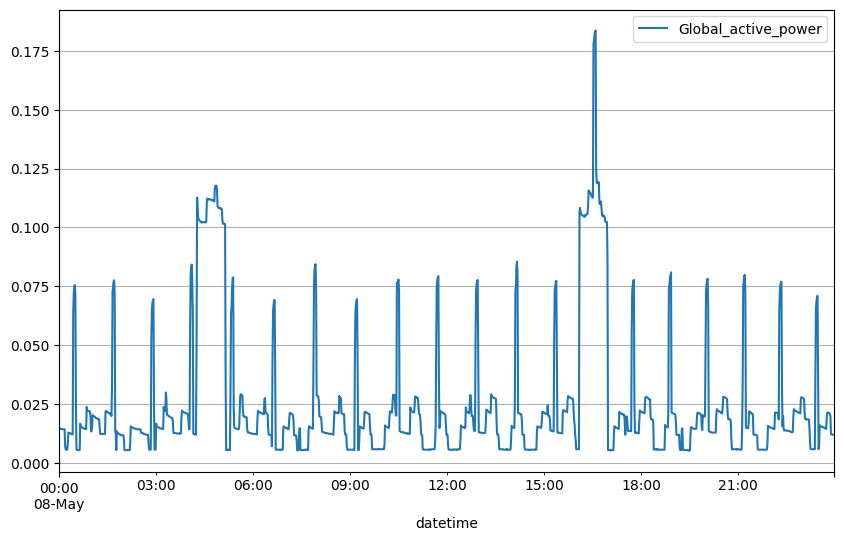

In [5]:
# Visualize power for a day
date1 ='2009-05-08'
_ = data.loc[date1].plot(kind='line', y='Global_active_power', figsize=(10,6), grid=True)
plt.show()
plt.close()

In [6]:
train_size = int(len(data) * 0.8)
train_data = data.iloc[:train_size].values
test_data = data.iloc[train_size:].values

def create_sequences(data, seq_len):
    """
    data: numpy array
        The input time series data
    seq_len: int
        The length of the input sequence
    """

    # initialize empty lists
    X = []
    y = []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_len = 6   # number of past time steps to use for prediction, this is a hyperparameter

# Create train and test sequences
X_train, y_train = create_sequences(train_data, seq_len)
X_test, y_test = create_sequences(test_data, seq_len)

# convert numpy arrays to PyTorch tensors
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])
        return out, hidden

**Explanation**:

* First, the class is initialized with `input_size`, `hidden_size`, and `output_size`. These parameters define the size of the input, hidden state, and output of the RNN.
* The `super(RNN, self).__init__()` line initializes the class as a subclass of the `nn.Module` class in PyTorch, which provides some useful methods for defining and training neural networks.
* The `self.hidden_size = hidden_size` line sets the hidden size as an attribute of the class, so it can be accessed later in the forward method.
* The `nn.RNN` module is defined with the `input_size` and `hidden_size` parameters. The `batch_first=True` parameter indicates that the input to the RNN will have the batch dimension as the first dimension.
* The `nn.Linear` module is defined with the `hidden_size` and `output_size` parameters. This module will be used to map the final hidden state of the RNN to the output.
* The forward method takes two arguments: `x` and `hidden`. `x` is the input to the RNN, which is a tensor of shape `(batch_size, seq_len, input_size)`. `hidden` is the initial hidden state of the RNN, which is a tensor of shape `(1, batch_size, hidden_size)`.
* The `nn.RNN` module is called with `x` and `hidden` as inputs, and the output is stored in `out`. The `out` tensor has shape `(batch_size, seq_len, hidden_size)`, where `seq_len` is the length of the input sequence.
* The `out[:, -1, :]` indexing extracts the last hidden state of the RNN for each sequence in the batch. This tensor has shape `(batch_size, hidden_size)`.
* The `nn.Linear` module is called with the last hidden state as input, and the output is stored in `out`. The `out` tensor has shape `(batch_size, output_size)`.
* Finally, the `out` and `hidden` tensors are returned as the output of the forward method.

Overall, this code defines a simple RNN model that takes an input sequence, processes it with an RNN layer, and maps the final hidden state to an output.

### Set Hyperparameters

In [8]:
input_size = 1   # number of features in the input
hidden_size = 32  # number of hidden units in the RNN layer
output_size = 1  # number of output features
learning_rate = 0.001
num_epochs = 100

# Tune the above hyperparameters for best results.

model = RNN(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Training the model

In [9]:
for epoch in range(num_epochs):
    # set the initial hidden state
    hidden = torch.zeros(1, X_train.size(0), hidden_size)

    # forward pass
    outputs, hidden = model(X_train, hidden)
    loss = criterion(outputs, y_train)

    # backwards and optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss at every 10th epoch
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {round(loss.item(), 4)}')

Epoch [10/100], Loss: 0.0145
Epoch [20/100], Loss: 0.0133
Epoch [30/100], Loss: 0.0093
Epoch [40/100], Loss: 0.009
Epoch [50/100], Loss: 0.0082
Epoch [60/100], Loss: 0.0077
Epoch [70/100], Loss: 0.0071
Epoch [80/100], Loss: 0.0065
Epoch [90/100], Loss: 0.0058
Epoch [100/100], Loss: 0.005


**Explanation**

* Loop through each epoch:
`for epoch in range(num_epochs):`
This loop iterates over the number of epochs specified in the num_epochs variable.
* Initialize the hidden state:
`hidden = torch.zeros(1, X_train.size(0), hidden_size)`
The hidden state of the RNN is initialized to all zeros. The size of the tensor is `(1, batch_size, hidden_size)` where `batch_size` is the number of samples in the training data and `hidden_size` is the number of hidden units in the RNN layer.
* Forward pass:
`outputs, hidden = model(X_train, hidden)`
The RNN model is passed the input `X_train` and the initial hidden state hidden to generate the outputs and update the hidden state. The outputs tensor has shape `(batch_size, seq_length, output_size)` where `seq_length` is the length of the input sequence and `output_size` is the number of output features.
* Calculate loss:
`loss = criterion(outputs, y_train)`
The loss is calculated based on the predicted outputs and the ground truth `y_train` using the mean squared error (MSE) loss.
* Backward pass and optimizer step:
    ```
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ```
    The gradients of the model parameters are zeroed out, and the loss is backpropagated through the network. The optimizer then updates the model parameters based on the gradients.
* Print loss:
    ```
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {round(loss.item(), 4)}')
    ```
    The loss is printed every 10th epoch using string formatting. The round function is used to round the loss to 4 decimal places.

### Model Evaluation

In [10]:
# Set initial hidden state for test data
hidden = torch.zeros(1, X_test.size(0), hidden_size)

# Forward pass
test_outputs, _ = model(X_test, hidden)

# Inverse normalize the output and inputs
test_outputs = (test_outputs * (max_power - min_power)) + min_power
y_test = (y_test * (max_power - min_power)) + min_power

# Compute the test loss
test_loss = criterion(test_outputs, y_test)

print(f'Test Loss: {round(test_loss.item(), 4)}')

Test Loss: 0.4253


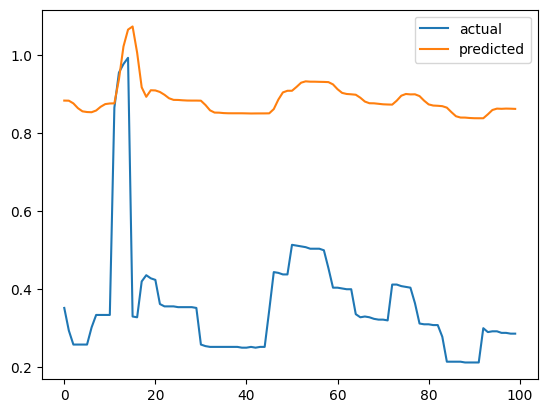

In [11]:
# Convert the output and labels to numpy arrays
test_outputs = test_outputs.detach().numpy()
y_test = y_test.numpy()
# Plot the first 100 actual and predicted values
plt.plot(y_test[200:300], label='actual')
plt.plot(test_outputs[200:300], label='predicted')
plt.legend()
plt.show()